In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("HealthAutoExport-2021-06-01-2023-06-20 Data.csv")
cols = [
        "Date",
        "Active Energy (kcal)",
        "Apple Exercise Time (min)",
        "Apple Stand Time (min)",
        "Basal Energy Burned (kcal)",
        "Flights Climbed (count)",
        "Heart Rate [Min] (count/min)",
        "Heart Rate [Max] (count/min)",
        "Heart Rate [Avg] (count/min)",
        "Resting Heart Rate (count/min)",
        "Sleep Analysis [Asleep] (hr)",
        "Sleep Analysis [In Bed] (hr)",
        "Sleep Analysis [Core] (hr)",
        "Sleep Analysis [Deep] (hr)",
        "Sleep Analysis [REM] (hr)",
        "Sleep Analysis [Awake] (hr)",
        "Stair Speed: Down (ft/s)",
        "Stair Speed: Up (ft/s)",
        "Step Count (count)",
    ]

df1 = df.loc[:,cols]
df2 = df1.set_index("Date")
df3 = df2.stack().reset_index()
df3.rename(columns = {"level_1":"health_data_type",0:"value"}, inplace = True)
df3.loc[:,"type_unit_of_measurement"] = df3.health_data_type.apply(lambda x: x.split(" (")[1][:-1] if " (" in x else None)
df3.loc[:,"type"] = df3.health_data_type.apply(lambda x: x.split(" (")[0].replace(":","").replace("Analysis ","").replace("Apple ","").replace(" ", "_").replace("[","").replace("]","").lower() if " (" in x else None)
df3["day_of_month"] = pd.to_datetime(df3["Date"]).dt.day
df3["month"] = pd.to_datetime(df3["Date"]).dt.month
df3["year"] = pd.to_datetime(df3["Date"]).dt.year

types_index = {x:ind for ind,x in enumerate(df3["type"].unique())}
date_index = {x:ind for ind,x in enumerate(df3["Date"].unique())}

df3.loc[:,"date_index"] = df3["Date"].apply(lambda x: date_index[x])
df3.loc[:,"type_index"] = df3["type"].apply(lambda x: types_index[x])

healthDataFact = df3.loc[:,["date_index","type_index","value"]]
healthDataDim = df3.loc[:,["type_index","type","type_unit_of_measurement"]].drop_duplicates()
dateDim = df3.loc[:,["date_index","day_of_month","month","year"]].drop_duplicates()

In [3]:
print(healthDataFact)

       date_index  type_index        value
0               0           0     2.000000
1               0           1     0.000000
2               0           2     6.824425
3               0           3     0.000000
4               0           4     0.000000
...           ...         ...          ...
10656         749           5     0.708333
10657         749           6     0.416667
10658         749          16     1.110000
10659         749          17     0.983000
10660         749           7  6069.000000

[10661 rows x 3 columns]


In [4]:
print(healthDataDim)

     type_index                 type type_unit_of_measurement
0             0      flights_climbed                    count
1             1         sleep_asleep                       hr
2             2         sleep_in_bed                       hr
3             3           sleep_core                       hr
4             4           sleep_deep                       hr
5             5            sleep_rem                       hr
6             6          sleep_awake                       hr
7             7           step_count                    count
146           8        active_energy                     kcal
147           9        exercise_time                      min
148          10           stand_time                      min
149          11  basal_energy_burned                     kcal
151          12       heart_rate_min                count/min
152          13       heart_rate_max                count/min
153          14       heart_rate_avg                count/min
154     

In [5]:
print(dateDim)

       date_index  day_of_month  month  year
0               0             1      6  2021
8               1             2      6  2021
16              2             3      6  2021
24              3             4      6  2021
32              4             5      6  2021
...           ...           ...    ...   ...
10596         745            16      6  2023
10604         746            17      6  2023
10622         747            18      6  2023
10631         748            19      6  2023
10643         749            20      6  2023

[750 rows x 4 columns]


In [6]:
import sqlite3

In [7]:
conn = sqlite3.connect('FinalProject.db')
c = conn.cursor()

In [8]:
c.execute("DROP TABLE IF EXISTS HealthFact;")

In [9]:
c.execute('''CREATE TABLE HealthFact(
    id INTEGER PRIMARY KEY,
    user_id INTEGER,
    date_id INTEGER,
    healthData_id INTEGER,
    value NUMERIC (10,2)
);''')

In [10]:
c.execute("DROP TABLE IF EXISTS UserDim;")

In [11]:
c.execute('''CREATE TABLE UserDim(
    id INTEGER PRIMARY KEY,
    name VARCHAR (100),
    email VARCHAR (100)
);''')

In [12]:
c.execute("DROP TABLE IF EXISTS DateDim;")

In [13]:
c.execute('''CREATE TABLE DateDim(
    id INTEGER PRIMARY KEY,
    day INTEGER (2),
    month INTEGER (2),
    year INTEGER (4)
);''')

In [14]:
c.execute("DROP TABLE IF EXISTS HealthDim;")

In [15]:
c.execute('''CREATE TABLE HealthDim(
    id INTEGER PRIMARY KEY,
    type VARCHAR (25),
    desc VARCHAR (255),
    unit_of_measurement VARCHAR (20)
);''')

In [16]:
c.execute("DROP TABLE IF EXISTS HealthClassifier;")

In [17]:
c.execute('''CREATE TABLE HealthClassifier(
    id INTEGER PRIMARY KEY,
    healthData_id INTEGER,
    classifier VARCHAR (25),
    lower_bound NUMERIC,
    upper_bound NUMERIC
);''')

In [18]:
for _, row in dateDim.iterrows():
    day = int(row["day_of_month"])
    month = int(row["month"])
    year = int(row["year"])

    c.execute("INSERT INTO DateDim (day, month, year) VALUES (?, ?, ?)", (day, month, year))
    
conn.commit()

In [19]:
c.execute("SELECT * FROM DateDim")
colnames = [row[0] for row in c.description]
df = pd.DataFrame(c.fetchall(), columns=colnames)
df.head()

,id,day,month,year
0,1,1,6,2021
1,2,2,6,2021
2,3,3,6,2021
3,4,4,6,2021
4,5,5,6,2021


In [20]:
user_id = 1

for _, row in healthDataFact.iterrows():
    date_id = row["date_index"]
    healthData_id = row["type_index"]
    value = row["value"]

    c.execute("INSERT INTO HealthFact (user_id, date_id, healthData_id, value) VALUES (?, ?, ?, ?)", (user_id, date_id, healthData_id, value))

conn.commit()

In [21]:
c.execute("SELECT * FROM HealthFact")
colnames = [row[0] for row in c.description]
df = pd.DataFrame(c.fetchall(), columns=colnames)
df.head()

,id,user_id,date_id,healthData_id,value
0,1,1,0,0,2.000000
1,2,1,0,1,0.000000
2,3,1,0,2,6.824425
3,4,1,0,3,0.000000
4,5,1,0,4,0.000000


In [22]:
descriptions = {
    "basal_energy_burned": "Calories burned during rest",
    "sleep_asleep": "Duration of deep sleep",
    "sleep_in_bed": "Time spent in bed",
    "sleep_core": "Duration of sleep cycle",
    "sleep_deep": "Duration of deep sleep",
    "sleep_rem": "Duration of REM sleep",
    "sleep_awake": "Duration of awake time during sleep",
    "step_count": "Number of steps taken",
    "active_energy": "Calories burned during activity",
    "exercise_time": "Duration of exercise",
    "stand_time": "Duration of standing",
    "flights_climbed": "Number of flights of stairs climbed",
    "heart_rate_min": "Minimum heart rate",
    "heart_rate_max": "Maximum heart rate",
    "heart_rate_avg": "Average heart rate",
    "resting_heart_rate": "Resting heart rate",
    "stair_speed_down": "Speed while descending stairs",
    "stair_speed_up": "Speed while ascending stairs"
}

for _, row in healthDataDim.iterrows():
    health_type = row["type"]
    unit_of_measurement = row["type_unit_of_measurement"]

    if health_type in descriptions:
        desc = descriptions[health_type]
    else:
        desc = None
    
    c.execute("INSERT INTO HealthDim (type, desc, unit_of_measurement) VALUES (?, ?, ?)",
              ( health_type, desc, unit_of_measurement))
    
conn.commit()

In [23]:
c.execute("SELECT * FROM HealthDim")
colnames = [row[0] for row in c.description]
df = pd.DataFrame(c.fetchall(), columns=colnames)
df

,id,type,desc,unit_of_measurement
0,1,flights_climbed,Number of flights of stairs climbed,count
1,2,sleep_asleep,Duration of deep sleep,hr
2,3,sleep_in_bed,Time spent in bed,hr
3,4,sleep_core,Duration of sleep cycle,hr
4,5,sleep_deep,Duration of deep sleep,hr
5,6,sleep_rem,Duration of REM sleep,hr
6,7,sleep_awake,Duration of awake time during sleep,hr
7,8,step_count,Number of steps taken,count
8,9,active_energy,Calories burned during activity,kcal
9,10,exercise_time,Duration of exercise,min


In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
#NULL value check
c.execute('''
SELECT * FROM HealthFact
''')
colnames = [row[0] for row in c.description]
df = pd.DataFrame(c.fetchall(), columns=colnames)
df.head()

,id,user_id,date_id,healthData_id,value
0,1,1,0,0,2.000000
1,2,1,0,1,0.000000
2,3,1,0,2,6.824425
3,4,1,0,3,0.000000
4,5,1,0,4,0.000000


In [26]:
#mean median
c.execute('''
SELECT 
    hF.user_id,
    dD.Year,
    hD.type,
    Round(AVG(hF.value),2) AS 'Average/Mean',
    Round(((MAX(hF.value) + MIN(hF.value)) / 2),2) AS 'Median'
FROM 
    healthFact hF 
INNER JOIN  
    dateDim dD ON hF.date_id = dD.id 
INNER JOIN 
    healthDim hD ON hF.healthData_id = hD.id 
GROUP BY 
    hF.user_id,
    dD.Year,
    hD.type
''')
colnames = c.description   # gather collumn names from a new query
colnames_list = []
for row in colnames:
    colnames_list.append(row[0])

df = pd.DataFrame(c.fetchall(), columns=colnames_list)
df.head()

,user_id,year,type,Average/Mean,Median
0,1,2021,active_energy,12.06,51.00
1,1,2021,basal_energy_burned,50.87,61.00
2,1,2021,exercise_time,57.25,170.00
3,1,2021,flights_climbed,4.96,4.61
4,1,2021,heart_rate_avg,58.02,66.00


In [27]:
#min max
c.execute('''
SELECT 
    hF.user_id,
    dD.Year,
    hD.type,
    Round(MAX(hF.value),2) AS 'Maximum value',
    Round(MIN(hF.value),2) AS 'Minimum value'
FROM 
    healthFact hF 
INNER JOIN  
    dateDim dD ON hF.date_id = dD.id 
INNER JOIN 
    healthDim hD ON hF.healthData_id = hD.id 

GROUP BY 
    hF.user_id,
    dD.Year,
    hD.type
''')
colnames = c.description   # gather collumn names from a new query
colnames_list = []
for row in colnames:
    colnames_list.append(row[0])

df = pd.DataFrame(c.fetchall(), columns=colnames_list)
df.head(10)

,user_id,year,type,Maximum value,Minimum value
0,1,2021,active_energy,102.00,1.00
1,1,2021,basal_energy_burned,82.00,40.00
2,1,2021,exercise_time,339.00,1.00
3,1,2021,flights_climbed,9.22,0.00
4,1,2021,heart_rate_avg,85.00,48.00
5,1,2021,heart_rate_max,95.45,58.44
6,1,2021,heart_rate_min,188.00,81.00
7,1,2021,resting_heart_rate,1.85,0.72
8,1,2021,sleep_asleep,13.63,4.36
9,1,2021,sleep_awake,20311.00,5.00


### 1.Average Energy Burned

Text(0.5, 1.0, 'Average Energy Burned')

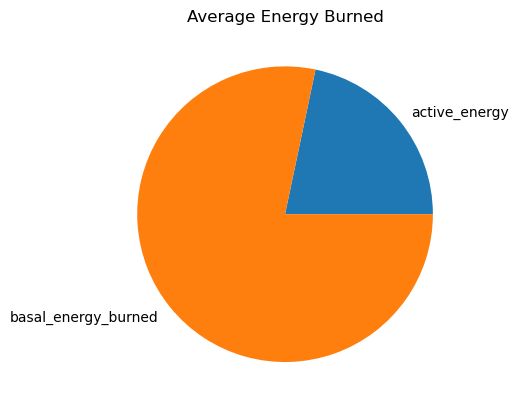

In [28]:

c.execute('''
SELECT 
    hD.type,
    Round(AVG(hF.value),2) as avg_time
FROM
    healthDim hD 
INNER JOIN 
    healthFact hF ON hD.id = hF.healthData_id 
WHERE
    type in ('active_energy', 'basal_energy_burned')
GROUP BY
    hD.type''')
colnames = c.description   # gather collumn names from a new query
colnames_list = []
for row in colnames:
    colnames_list.append(row[0])

df = pd.DataFrame(c.fetchall(), columns=colnames_list)
df

labels = df['type']
sizes = df['avg_time']

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels)
plt.title('Average Energy Burned')


### 2. Running Totals

Text(0.5, 1.0, 'Running Totals')

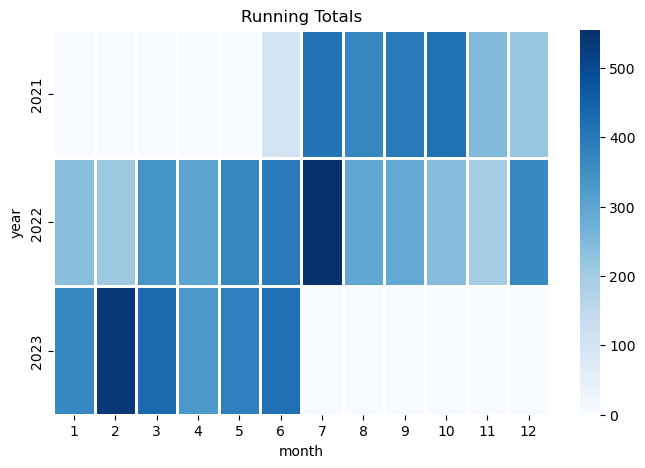

In [30]:

c.execute('''
SELECT 
    dD.year,
    dD.month,
    round(SUM(hF.value),2) value
FROM
    healthFact hF
INNER JOIN 
    healthDim hD on hF.healthData_id = hD.id
INNER JOIN 
    dateDim dD on hF.date_id = dD.id
WHERE
    type in ('active_energy')
GROUP BY 
    dD.year,
    dD.month
''')

colnames = c.description   # gather collumn names from a new query
colnames_list = []
for row in colnames:
    colnames_list.append(row[0])
    
df = pd.DataFrame(c.fetchall(), columns=colnames_list)
df

x = df.pivot('year','month','value')
x = x.fillna(0)
x

plt.figure(figsize = (8,5))
ax = sns.heatmap(x,linewidth = 1,cmap = 'Blues')
#ax.set(xlabel='X-Axis', ylabel='Y-Axis')
plt.title('Running Totals')

### 3. week, user is most active

In [31]:

c.execute('''
select 
    dD.year,
    dD.month,
    strftime('%W', date(year ||'-01-01','+'||(month-1)||' month') ) week,
    hD.unit_of_measurement,
    max(hF.value) value
FROM
    healthFact hF
INNER JOIN
    dateDim dD on hF.date_id = dD.id
INNER JOIN 
    healthDim hD on hF.healthData_id = hD.id
where hD.type = 'active_energy'
GROUP BY
    dD.year,
    dD.month,
    week,
    hD.unit_of_measurement;
''')

colnames = c.description   # gather collumn names from a new query
colnames_list = []
for row in colnames:
    colnames_list.append(row[0])

df = pd.DataFrame(c.fetchall(), columns=colnames_list)
df.head(10)


,year,month,week,unit_of_measurement,value
0,2021,6,22,kcal,22
1,2021,7,26,kcal,62
2,2021,8,30,kcal,102
3,2021,9,35,kcal,55
4,2021,10,39,kcal,86
5,2021,11,44,kcal,24
6,2021,12,48,kcal,22
7,2022,1,00,kcal,31
8,2022,2,05,kcal,24
9,2022,3,09,kcal,66


### 4. top 3 activities

<AxesSubplot:xlabel='type', ylabel='value'>

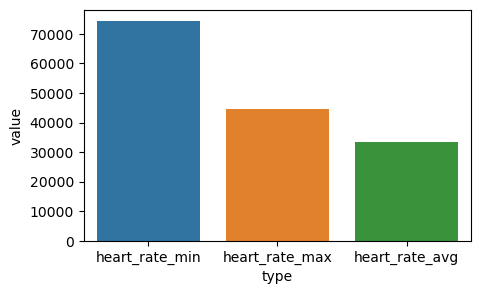

In [32]:

c.execute('''
select
    hD.type,
    hD.unit_of_measurement,
    Round(sum(hF.value),2) value
FROM
    healthFact hF
INNER JOIN 
    healthDim hD on hF.healthData_id = hD.id
WHERE 
    hD.unit_of_measurement = 'count/min'
GROUP BY
    hD.type,
    hD.unit_of_measurement
ORDER BY 
    sum(hF.value)  desc  limit 3;
''')

colnames = c.description   # gather collumn names from a new query
colnames_list = []
for row in colnames:
    colnames_list.append(row[0])

df = pd.DataFrame(c.fetchall(), columns=colnames_list)
df

plt.figure(figsize=(5,3))
sns.barplot(data=df, x="type", y="value")



### 5. monthly sleep analysis

Text(0.5, 1.0, 'Sleep Analysis')

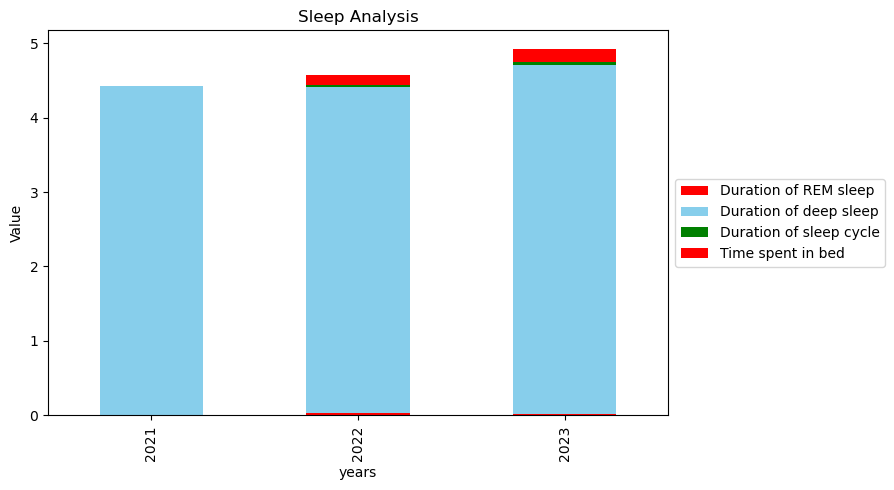

In [33]:

 
sql = c.execute('''
select
    dD.year,
    hD.desc,
    Round(avg(hF.value),2) value
FROM
    healthFact hF
INNER JOIN 
    healthDim hD on hF.healthData_id = hD.id
INNER JOIN 
    dateDim dD on hF.date_id = dD.id
WHERE
    type like '%sleep%' 
   and  type not like '%awake%'
GROUP BY
    dD.year,
    hD.desc
''')

colnames = c.description   # gather collumn names from a new query
colnames_list = []
for row in colnames:
    colnames_list.append(row[0])

df = pd.DataFrame(c.fetchall(), columns=colnames_list)
df

x = df.pivot('year','desc','value')
x = x.fillna(0)
x

# create stacked bar chart for monthly temperatures
x.plot(kind='bar', stacked=True, color=['red', 'skyblue', 'green'],figsize=(8,5))
 
# labels for x & y axis
plt.xlabel('years')
plt.ylabel('Value')

# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# title of plot
plt.title('Sleep Analysis')

